<a href="https://colab.research.google.com/github/fortune-max/M4-python-refresher-ml/blob/main/Day11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Decision trees: https://education.yandex.ru/handbook/ml/article/reshayushchiye-derevya \
Ansembles: https://education.yandex.ru/handbook/ml/article/ansambli-v-mashinnom-obuchenii \
gradient boosting: https://education.yandex.ru/handbook/ml/article/gradientnyj-busting


# Sofisticated estimators


XGBoost
https://colab.research.google.com/github/rasgointelligence/feature-engineering-tutorials/blob/main/feature-importance/XGBoost%20Feature%20Importance.ipynb

https://colab.research.google.com/drive/1H0DMyi1h3RoKYsWe0E5ZHrAdhBQkPxtg

Catboost
https://catboost.ai/

https://colab.research.google.com/github/catboost/tutorials/blob/master/python_tutorial.ipynb

Vowpal wabbit
https://vowpalwabbit.org/

https://colab.research.google.com/drive/1Muq0SY_X3gm9jrO7oemLkc5Xh1eADTE1?usp=sharing#scrollTo=75T7tx4nWCqT

[ ]


# XGBoost Feature Importance

This notebook explains how to generate feature importance plots from `XGBoost` using tree-based feature importance, permutation importance and `shap`.

This notebook will build and evaluate a model to predict arrival delay for flights in and out of NYC in 2013.  

### Packages

This tutorial uses:
* [pandas](https://pandas.pydata.org/docs/)
* [statsmodels](https://www.statsmodels.org/stable/index.html)
    * [statsmodels.api](https://www.statsmodels.org/stable/api.html#statsmodels-api)
* [matplotlib](https://matplotlib.org/)
    * [matplotlib.pyplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html)
* [numpy](https://numpy.org/doc/stable/)
* [scikit-learn](https://scikit-learn.org/stable/)
    * [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html)
    * [sklearn.model_selection](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    * [sklearn.inspection](https://scikit-learn.org/stable/inspection.html)
* [shap](https://shap.readthedocs.io/en/latest/index.html)
* [category_encoders](https://contrib.scikit-learn.org/category_encoders/)
* [XGBoost](https://xgboost.readthedocs.io/en/latest/)

In [ ]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import shap
import category_encoders as ce

import xgboost as xgb

## Reading the data

The data is from `rdatasets` imported using the Python package `statsmodels`.

In [ ]:
df = sm.datasets.get_rdataset('flights', 'nycflights13').data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336776 entries, 0 to 336775
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year            336776 non-null  int64  
 1   month           336776 non-null  int64  
 2   day             336776 non-null  int64  
 3   dep_time        328521 non-null  float64
 4   sched_dep_time  336776 non-null  int64  
 5   dep_delay       328521 non-null  float64
 6   arr_time        328063 non-null  float64
 7   sched_arr_time  336776 non-null  int64  
 8   arr_delay       327346 non-null  float64
 9   carrier         336776 non-null  object 
 10  flight          336776 non-null  int64  
 11  tailnum         334264 non-null  object 
 12  origin          336776 non-null  object 
 13  dest            336776 non-null  object 
 14  air_time        327346 non-null  float64
 15  distance        336776 non-null  int64  
 16  hour            336776 non-null  int64  
 17  minute    

## Feature Engineering

### Handle null values

In [ ]:
df.isnull().sum()

year                 0
month                0
day                  0
dep_time          8255
sched_dep_time       0
dep_delay         8255
arr_time          8713
sched_arr_time       0
arr_delay         9430
carrier              0
flight               0
tailnum           2512
origin               0
dest                 0
air_time          9430
distance             0
hour                 0
minute               0
time_hour            0
dtype: int64

As this model will predict arrival delay, the `Null` values are caused by flights did were cancelled or diverted. These can be excluded from this analysis.

In [ ]:
df.dropna(inplace=True)

### Convert the times from floats or ints to hour and minutes

In [ ]:
df['arr_hour'] = df.arr_time.apply(lambda x: int(np.floor(x/100)))
df['arr_minute'] = df.arr_time.apply(lambda x: int(x - np.floor(x/100)*100))
df['sched_arr_hour'] = df.sched_arr_time.apply(lambda x: int(np.floor(x/100)))
df['sched_arr_minute'] = df.sched_arr_time.apply(lambda x: int(x - np.floor(x/100)*100))
df['sched_dep_hour'] = df.sched_dep_time.apply(lambda x: int(np.floor(x/100)))
df['sched_dep_minute'] = df.sched_dep_time.apply(lambda x: int(x - np.floor(x/100)*100))
df.rename(columns={'hour': 'dep_hour',
                   'minute': 'dep_minute'}, inplace=True)

## Prepare data for modeling

### Set up train-test split

In [ ]:
target = 'arr_delay'
y = df[target]
X = df.drop(columns=[target, 'flight', 'tailnum', 'time_hour', 'year', 'dep_time', 'sched_dep_time', 'arr_time', 'sched_arr_time', 'dep_delay'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1066)

### Encode categorical variables

We use a leave-one-out encoder as it creates a single column for each categorical variable instead of creating a column for each level of the categorical variable like one-hot-encoding.  This makes interpreting the impact of categorical variables with feature impact easier.

In [ ]:
encoder = ce.LeaveOneOutEncoder(return_df=True)
X_train_loo = encoder.fit_transform(X_train, y_train)
X_test_loo = encoder.transform(X_test)

## Fit the model

In [ ]:
model = xgb.XGBRegressor(n_estimators=500, max_depth=5, eta=0.05)
model.fit(X_train_loo, y_train)

rmse = np.sqrt(mean_squared_error(y_test, model.predict(np.ascontiguousarray(X_test_loo))))
rmse

43.33026958963029

## Feature Importance

### Plot the tree-based (or Gini) importance

Text(0.5, 1.0, 'Feature Importance')

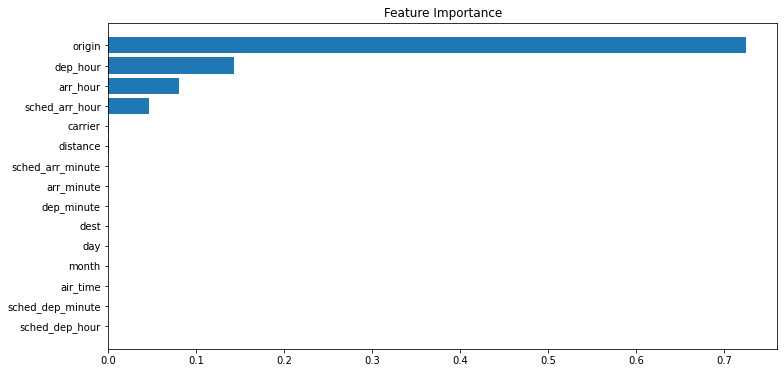

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

### Plot the permutation importance.

Text(0.5, 1.0, 'Permutation Importance')

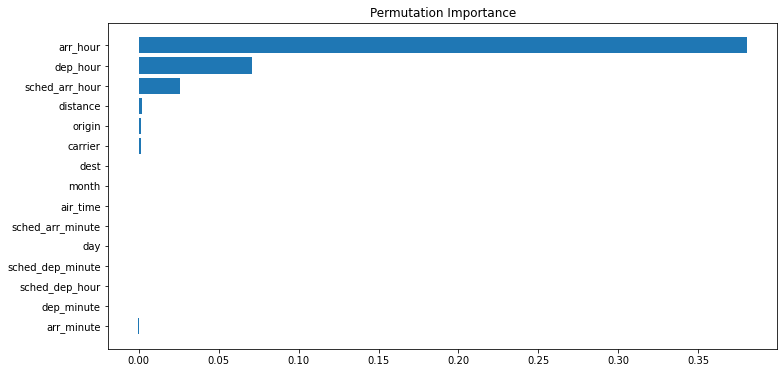

In [ ]:
perm_importance = permutation_importance(model, np.ascontiguousarray(X_test_loo), y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')

### Plot the mean absolute value of the SHAP values

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Text(0.5, 1.0, 'SHAP Importance')

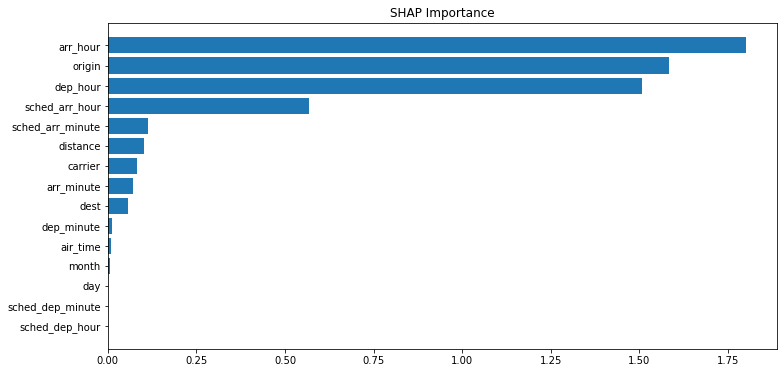

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(np.ascontiguousarray(X_test_loo))
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('SHAP Importance')

`SHAP` contains a function to plot this directly.

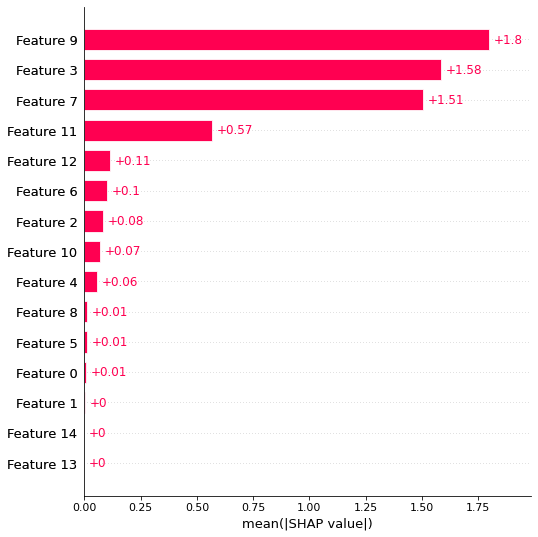

In [ ]:
shap.plots.bar(shap_values, max_display=X_test_loo.shape[0])

# AutoML: Parameters search

In [ ]:
titanic_df = pd.read_csv('titanic.csv')

In [ ]:
from sklearn import model_selection

In [ ]:
X_train,X_test, y_train, y_test = model_selection.train_test_split(
    titanic_df.drop('Survived', axis=1),
    titanic_df['Survived'])

In [ ]:
X_train

PassengerId  Pclass                                Name     Sex   Age  \
539          540       1  Frolicher, Miss. Hedwig Margaritha  female  22.0   
159          160       3          Sage, Master. Thomas Henry    male   NaN   
216          217       3              Honkanen, Miss. Eliina  female  27.0   
751          752       3                 Moor, Master. Meier    male   6.0   
514          515       3                   Coleff, Mr. Satio    male  24.0   
..           ...     ...                                 ...     ...   ...   
191          192       2               Carbines, Mr. William    male  19.0   
342          343       2          Collander, Mr. Erik Gustaf    male  28.0   
680          681       3                 Peters, Miss. Katie  female   NaN   
139          140       1                  Giglio, Mr. Victor    male  24.0   
301          302       3                  McCoy, Mr. Bernard    male   NaN   

     SibSp  Parch            Ticket     Fare Cabin Embarked  
539      0      2             13568  49.5000   B39        C  
159      8      2          CA. 2343  69.5500   NaN        S  
216      0      0  STON/O2. 3101283   7.9250   NaN        S  
751      0      1            392096  12.4750  E121        S  
514      0      0            349209   7.4958   NaN        S  
..     ...    ...               ...      ...   ...      ...  
191      0      0             28424  13.0000   NaN        S  
342      0      0            248740  13.0000   NaN        S  
680      0      0            330935   8.1375   NaN        Q  
139      0      0          PC 17593  79.2000   B86        C  
301      2      0            367226  23.2500   NaN        Q  

[668 rows x 11 columns]

#### for classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
classifier = RandomForestClassifier()

In [ ]:
grid_param = # provide your code here

In [ ]:
from sklearn import model_selection

### Grid Search

In [ ]:
grid_search_classifier = # provide your code here

In [ ]:
%%time
# provide your code here
#train

In [ ]:
best_parameters = # provide your code here

In [ ]:
best_score = # provide your code here

In [ ]:
cv_results = # provide your code here

### Random search

In [ ]:
random_search_classifier = # provide your code here

In [ ]:
%%time
# provide your code here
#train

In [ ]:
best_parameters = # provide your code here

In [ ]:
best_score = # provide your code here

In [ ]:
cv_results = # provide your code here

#### for pipeline

### auto-sklearn

In [ ]:
!pip install auto-sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.5 MB 4.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 4.9 MB 45.8 MB/s 
     |████████████████████████████████| 24.9 MB 1.5 MB/s 
     |████████████████████████████████| 260 kB 59.0 MB/s 
     |████████████████████████████████| 4.4 MB 46.9 MB/s 
     |████████████████████████████████| 46 kB 4.5 MB/s 
  Created wheel for auto-sklearn: filename=auto_sklearn-0.15.0-py3-none-any.whl size=6641945 sha256=0022bfb00aeeabcfa8993f934341bc76239c67b176eb52f800bd1715ad9b55f8
  Stored in directory: /root/.cache/pip/wheels/c5/11/0e/aeac2cee929fa4388e528737b49deb2eea05486e6f80d61c1a
  Created wheel for pynisher: filename=pynisher-0.6.4-py3-none-any.whl size=7044 sha256=9d885e7d00901121736bcb8b383cce04f6e03c11edaf4d31cedb8a2e954c54ac
  Sto

In [ ]:
import autosklearn.classification

In [ ]:
automl = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=60)

In [ ]:
%%time
automl.fit(X_train[ ['Pclass', 'SibSp','Fare' ] ], y_train)

CPU times: user 3.41 s, sys: 627 ms, total: 4.03 s
Wall time: 57.1 s


AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      per_run_time_limit=6, time_left_for_this_task=60)

In [ ]:
from sklearn import metrics

In [ ]:
y_hat = automl.predict(X_test[ ['Pclass', 'SibSp','Fare' ] ])
print("Accuracy score", metrics.accuracy_score(y_test, y_hat))

Accuracy score 0.6995515695067265


In [ ]:
automl.show_models()

{2: {'model_id': 2,
  'rank': 1,
  'cost': 0.32579185520361986,
  'ensemble_weight': 0.06,
  'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice at 0x7fe0455dff10>,
  'balancing': Balancing(random_state=1),
  'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice at 0x7fe0455df7c0>,
  'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice at 0x7fe045a09a60>,
  'sklearn_classifier': RandomForestClassifier(max_features=1, n_estimators=512, n_jobs=1,
                         random_state=1, warm_start=True)},
 5: {'model_id': 5,
  'rank': 2,
  'cost': 0.3529411764705882,
  'ensemble_weight': 0.02,
  'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice at 0x7fe0459e2f70>,
  'balancing': Balancing(random_state=1, strategy='weighting'),
  'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocess